<h1 style = "text-align :center; color:white; background-image:url(https://cdn.pixabay.com/photo/2014/06/16/23/40/blue-370128__340.png)"> About Competition </h1>

<h2 style="border-style: outset;border-color: red;text-align: center;">SIIM-FISABIO-RSNA COVID-19 Study Level Predictions</h2>

<img src="https://content.presspage.com/uploads/2110/gettyimages-1214942330.jpg" height="500" width="500" style="display: block;margin-left: auto;margin-right: auto;"> 

<h2 style="text-align: center;border-style: double;text-align: center;border-color: red; ">About SIIM</h2>
<img src="https://siim.org/resource/resmgr/SIIM_logo-600x315.png" width="200" style="display: block;margin-left: auto;margin-right: auto;">
<p> <b>Society for Imaging Informatics in Medicine</b> (<a href="https://siim.org/">SIIM</a>) is the leading healthcare professional organization for those interested in the current and future use of informatics in medical imaging. The society's mission is to advance medical imaging informatics across the enterprise through education, research, and innovation in a multi-disciplinary community.</p>

<h3 style = "text-align :center; color:red; background-color: yellow; ">This is my first Data Visualization Notebook. Kindly comment if there are any mistakes 🙂</h3>

<a href = "https://www.kaggle.com/shanmukh05/siim-covid19-dataset-256px-jpg" style="font-weight:'bold'; color:blue; font-family:monospace; "><h3>My Dataset</h3></a>

<a href = "https://www.kaggle.com/shanmukh05/siim-covid-19-data-preparation-for-detectron2" style="font-weight:'bold'; color:blue; font-family:monospace; "><h3>My Data Preparation Notebook</h3></a> 

<a href = "https://www.kaggle.com/shanmukh05/siim-covid-19-yolo-v5-image-level-predictions/output" style="font-weight:'bold'; color:blue; font-family:monospace; "><h3>YOLO v5 Image Level Training Notebook</h3></a> 

<a href = "https://www.kaggle.com/shanmukh05/siim-covid-19-detection-detectron2-training" style="font-weight:'bold'; color:blue; font-family:monospace; "><h3>My Training Notebook</h3></a> 
To be updated

<h2 style = "text-align :center; font-family:verdana; color:red; background-image: url(https://hookagency.com/wp-content/uploads/2015/11/miracle-grow-light-green-gradient.jpg); ">Install Requirements</h2>

In [1]:
!/opt/conda/bin/python3.7 -m pip install --upgrade pip
! pip install -q efficientnet

     |████████████████████████████████| 1.5 MB 2.9 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.0.1
    Uninstalling pip-21.0.1:
      Successfully uninstalled pip-21.0.1


<h2 style = "text-align :center; font-family:verdana; color:black; background-image: url(https://i.pinimg.com/originals/dd/f9/97/ddf997d65d8b92a3d7e085d6bf1cc484.jpg); ">Importing Dependencies</h2>

In [2]:
#-------------------
# importing libraries
#-------------------
import tensorflow as tf
from tensorflow.keras import layers
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold,StratifiedKFold

from kaggle_datasets import KaggleDatasets


import pandas as pd
import numpy as np

import os
import shutil
import csv

import matplotlib.pyplot as plt
import PIL

<h2 style = "text-align :center; font-family:verdana; color:red; background-image: url(https://hookagency.com/wp-content/uploads/2015/11/miracle-grow-light-green-gradient.jpg); ">Checking TPU access</h2>

In [3]:
AUTO = tf.data.experimental.AUTOTUNE

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path("siim-covid19-dataset-256px-jpg")
print(GCS_DS_PATH)

TRAIN_PATH = GCS_DS_PATH + "/224px/train/train/"
TEST_PATH = GCS_DS_PATH + "/224px/test/test/"

NUM_CLASSES = 4
HEIGHT,WIDTH = 224,224
CHANNELS = 3
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
SEED = 143


classes_dict = {
    "Negative for Pneumonia" : 0,
    "Typical Appearance" : 1,
    "Indeterminate Appearance" : 2,
    "Atypical Appearance"  : 3
}

study_df = pd.read_csv("../input/siim-covid19-detection/train_study_level.csv")
train_df = pd.read_csv('../input/siim-covid19-dataset-256px-jpg/train.csv')
train_df = train_df[["ImageInstanceUID","StudyInstanceUID","label_id","study_label"]]

gs://kds-b2852654b54daafc77f77314762f0e718d849a79a36206b0d80c9da7


In [5]:
train_df.head(3)

,ImageInstanceUID,StudyInstanceUID,label_id,study_label
0,000a312787f2,5776db0cec75,Typical Appearance,1
1,000c3a3f293f,ff0879eb20ed,Negative for Pneumonia,0
2,0012ff7358bc,9d514ce429a7,Typical Appearance,1


In [6]:
study_df.head(3)

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0


<h2 style = "text-align :center; font-family:verdana; color:black; background-image: url(https://i.pinimg.com/originals/dd/f9/97/ddf997d65d8b92a3d7e085d6bf1cc484.jpg); ">Utility Functions for Data Preprocessing</h2>

In [7]:
def process_img(filepath,label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32) 
    #image = tf.image.resize(image, [HEIGHT,WIDTH])
    return image,label


def data_augment(image, label):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) 
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) 
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) 
        
    
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    
    if p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.8), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
    
    image = tf.image.resize(image, [HEIGHT,WIDTH])
    return image,label

def get_dataset(filenames,labels, training=True):
    dataset = tf.data.Dataset.from_tensor_slices((filenames,labels))
    dataset = dataset.map(process_img,num_parallel_calls=AUTO)
    dataset = dataset.map(data_augment,num_parallel_calls=AUTO)
    dataset = dataset.cache()
    dataset = dataset.repeat()
    if training:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

<h2 style = "text-align :center; font-family:verdana; color:black; background-image: url(https://i.pinimg.com/originals/dd/f9/97/ddf997d65d8b92a3d7e085d6bf1cc484.jpg); ">Model Function</h2>

In [8]:
def create_model():
    
    pretrained = efn.EfficientNetB4(include_top=False, weights='noisy-student',input_shape=[HEIGHT,WIDTH, 3])
            
    x = pretrained.output
    x = tf.keras.layers.GlobalAveragePooling2D() (x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES,activation="softmax", dtype='float32')(x)
        
    model = tf.keras.Model(pretrained.input, outputs)
    return model

model = create_model()
#model.summary()

71680000/71678424 [==============================] - 1s 0us/step


In [9]:
#chxnet model

with strategy.scope():
    model = tf.keras.applications.DenseNet121(weights= "imagenet",
                                    include_top=False,
                                    input_shape=(HEIGHT,WIDTH,CHANNELS), pooling="avg")
    predictions = tf.keras.layers.Dense(14, activation='sigmoid', name='predictions')(model.output)

    model = tf.keras.Model(inputs=model.input, outputs=predictions)   
    model.load_weights("../input/pneumonia-classification-challenge/pretrained.h5")
    model = tf.keras.Model(model.input, model.layers[-2].output) 
    x = tf.keras.layers.Dense(512, activation = "relu")(model.output)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation = "relu")(x)
    x = tf.keras.layers.Dense(64, activation = "relu")(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation = "softmax", dtype = tf.float32)(x)

    chxnet = tf.keras.Model(model.input,outputs)

    for layer in chxnet.layers[:-15]:
        layer.trainble = False

29089792/29084464 [==============================] - 0s 0us/step


<h2 style = "text-align :center; font-family:verdana; color:black; background-image: url(https://i.pinimg.com/originals/dd/f9/97/ddf997d65d8b92a3d7e085d6bf1cc484.jpg); ">Compiling the Model</h2>

In [10]:
import tensorflow_addons as tfa

def compile_model(model, lr=0.001):
    
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    loss = tf.keras.losses.CategoricalCrossentropy()
   
    metrics = [
       tfa.metrics.F1Score(num_classes = NUM_CLASSES,average = "macro", name = "f1_score"),
       tf.keras.metrics.CategoricalAccuracy(name='acc')
    ]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

<h2 style = "text-align :center; font-family:verdana; color:black; background-image: url(https://i.pinimg.com/originals/dd/f9/97/ddf997d65d8b92a3d7e085d6bf1cc484.jpg); ">Model Callbacks</h2>

In [11]:
METRIC = "val_acc"

def create_callbacks(kfold,metric = METRIC):
    
    cpk_path = f'./best_model_{kfold}.h5'
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path,
        monitor= metric,
        mode='max',
        save_best_only=True,
        verbose=1,
    )

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor= metric,
        mode='max',
        factor=0.1,
        patience=3,
        verbose=0
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor= metric,
        mode='max',
        patience=10, 
        verbose=1
    )
    
    callbacks = [checkpoint, reducelr, earlystop]         
    
    return callbacks

<h2 style = "text-align :center; font-family:verdana; color:black; background-image: url(https://i.pinimg.com/originals/dd/f9/97/ddf997d65d8b92a3d7e085d6bf1cc484.jpg); ">Training</h2>

In [12]:
files_ls = tf.io.gfile.glob(TRAIN_PATH + "*.jpg" )
files_df = pd.DataFrame(files_ls, columns = ["filepath"])

labels = np.zeros((len(files_ls),NUM_CLASSES))
tmp_labels = np.zeros((len(files_ls)))

def get_id(filepath):
    tmp = filepath.split("/")[-1]
    tmp = tmp.split(".")[0]
    tmp = tmp.split("_")[-1]
    return tmp

for i in range(len(files_ls)):
    image_id = get_id(files_ls[i])
    label_id = train_df[train_df["ImageInstanceUID"] == image_id]["study_label"]
    labels[i][label_id] = 1
    tmp_labels[i] = label_id
    
print("Labels shape: ",labels.shape)

Labels shape:  (6334, 4)


In [13]:
EPOCHS = 30
VERBOSE = 1
N_SPLITS = 5

kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
history = {}


for fold,(tID,vID) in enumerate(kfold.split(files_ls,tmp_labels)):
    tFiles, tLabels = list(files_df.iloc[tID]["filepath"]) , labels[tID]
    vFiles, vLabels = list(files_df.iloc[vID]["filepath"]) , labels[vID]
    print("Number of Training Images: ",len(tID))
    print("Number of Validation Images: ",len(vID))
    
    STEPS_PER_EPOCH  = len(tID)//BATCH_SIZE
    VALID_STEPS = len(vID)//BATCH_SIZE
    
    tf.keras.backend.clear_session()
    
    train_ds = get_dataset(tFiles,tLabels, training = True)
    val_ds = get_dataset(vFiles, vLabels, training = False)
    
    with strategy.scope():
        #model = create_model()
        model = chxnet
        model = compile_model(model, lr=0.0001)
        callbacks = create_callbacks(kfold = fold)
    
        print("------------------Fold - ",fold+1," --------------------------")
        history[fold] = model.fit(
                            train_ds,
                            epochs=EPOCHS,
                            callbacks=callbacks,
                            validation_data = val_ds,
                            verbose=VERBOSE,
                            steps_per_epoch = STEPS_PER_EPOCH,
                            validation_steps=VALID_STEPS
                           )

Number of Training Images:  5067
Number of Validation Images:  1267
------------------Fold -  1  --------------------------
Epoch 1/30
79/79 [==============================] - 305s 2s/step - loss: 1.2547 - f1_score: 0.1783 - acc: 0.4647 - val_loss: 1.1749 - val_f1_score: 0.2059 - val_acc: 0.4942

Epoch 00001: val_acc improved from -inf to 0.49424, saving model to ./best_model_0.h5
Epoch 2/30
79/79 [==============================] - 8s 99ms/step - loss: 1.1326 - f1_score: 0.2650 - acc: 0.5345 - val_loss: 1.0547 - val_f1_score: 0.3229 - val_acc: 0.5847

Epoch 00002: val_acc improved from 0.49424 to 0.58470, saving model to ./best_model_0.h5
Epoch 3/30
79/79 [==============================] - 8s 106ms/step - loss: 1.0388 - f1_score: 0.3398 - acc: 0.6032 - val_loss: 1.0304 - val_f1_score: 0.3434 - val_acc: 0.6069

Epoch 00003: val_acc improved from 0.58470 to 0.60691, saving model to ./best_model_0.h5
Epoch 4/30
79/79 [==============================] - 8s 99ms/step - loss: 1.0081 - f1_scor

<h2 style = "text-align :center; font-family:verdana; color:black; background-image: url(https://i.pinimg.com/originals/dd/f9/97/ddf997d65d8b92a3d7e085d6bf1cc484.jpg); ">History Plotting</h2>

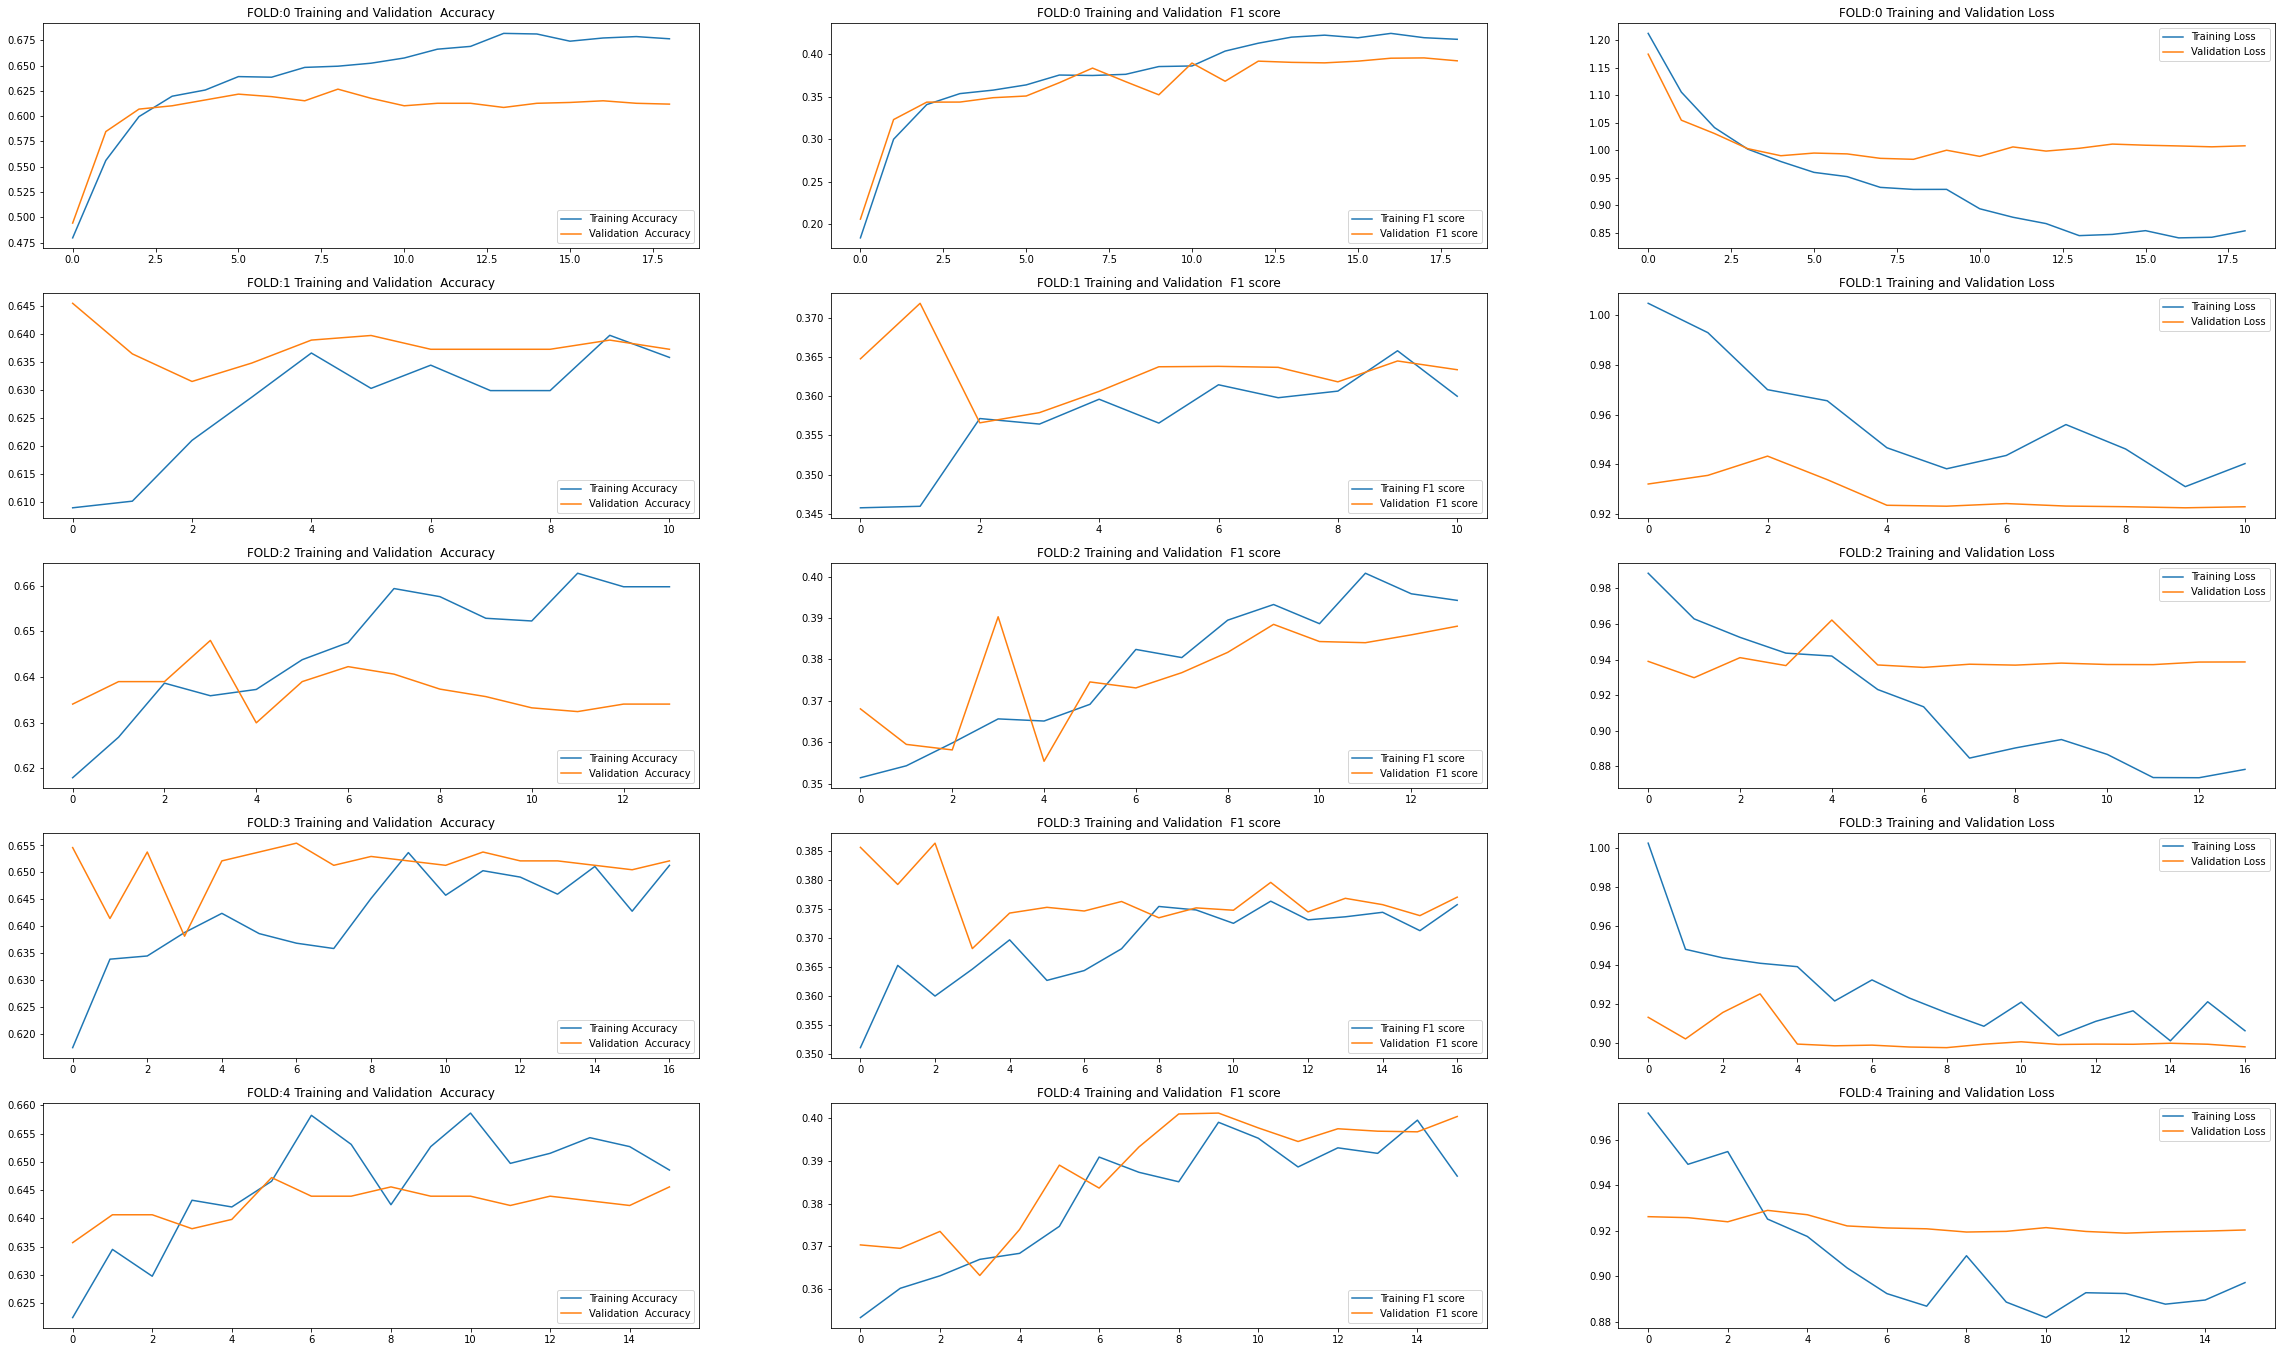

In [14]:
plt.figure(figsize=(8*N_SPLITS,24))

for i in range(N_SPLITS):
    acc = history[i].history['acc']
    val_acc = history[i].history['val_acc']
    f1 = history[i].history['f1_score']
    val_f1 = history[i].history['val_f1_score']
    loss = history[i].history['loss']
    val_loss = history[i].history['val_loss']
    epochs_range = range(len(history[i].history['val_loss'])) 
    
    plt.subplot(N_SPLITS, 3,i*3+1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation  Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'FOLD:{str(i)} Training and Validation  Accuracy')
    
    plt.subplot(N_SPLITS, 3,i*3+2)
    plt.plot(epochs_range, f1, label='Training F1 score')
    plt.plot(epochs_range, val_f1, label='Validation  F1 score')
    plt.legend(loc='lower right')
    plt.title(f'FOLD:{str(i)} Training and Validation  F1 score')
    
    plt.subplot(N_SPLITS, 3, i*3+3)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'FOLD:{str(i)} Training and Validation Loss')

plt.show()